In [1]:
import xarray as xr
from emit_tools import emit_xarray
import os
from fsspec.implementations.http import HTTPFileSystem
import numpy as np
import math

In [2]:
# Generate a user token and set it as an environment variable
# Tokens can be generated at https://urs.earthdata.nasa.gov/users/<username>/user_tokens
token = os.environ.get('EARTHDATA_TOKEN')
if token is None:
    raise ValueError('Please set the EARTHDATA_TOKEN environment variable')

In [3]:
%%time
# Loading data can take around 4 minutes on a 100Mbps connection

# kernel = "EMIT_L2A_RFL_001_20230123T004529_2302216_003" # Hobart
kernel = "EMIT_L2A_RFL_001_20230316T045211_2307503_006" # Canberra

s3_url = "s3://lp-prod-protected/EMITL2ARFL.001/" + kernel + "/" + kernel + ".nc"
s3_url = s3_url.replace("s3://", "https://data.lpdaac.earthdatacloud.nasa.gov/")

fs = HTTPFileSystem(headers={
    "Authorization": f"bearer {token}"
})
ds = emit_xarray(fs.open(s3_url))
ds

CPU times: user 12 s, sys: 9.43 s, total: 21.4 s
Wall time: 2min 25s


<xarray.Dataset>
Dimensions:           (latitude: 1919, longitude: 2400, bands: 285)
Coordinates:
  * latitude          (latitude) float64 -34.39 -34.39 -34.39 ... -35.43 -35.43
  * longitude         (longitude) float64 148.6 148.6 148.6 ... 149.9 149.9
    fwhm              (bands) float32 8.415 8.415 8.415 ... 8.806 8.807 8.809
    good_wavelengths  (bands) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    wavelengths       (bands) float32 381.0 388.4 395.8 ... 2.486e+03 2.493e+03
    spatial_ref       int64 0
Dimensions without coordinates: bands
Data variables:
    reflectance       (latitude, longitude, bands) float32 nan nan ... nan nan
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.48552998e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20230316T045211_23075...
    Orthorectified:                    True

## Plot bands as an RGB image

In [4]:
# 650 = Red, 560 = Green and 470 = Blue
# Change these to other bands and this will select the closest band
band_1 = 650
band_2 = 560
band_3 = 470

band_indices = np.array([np.nanargmin(abs(ds['wavelengths'].values - x)) for x in [band_1, band_2, band_3]])
ds["band_1"] = ds.reflectance.isel(bands=band_indices[0])
ds["band_2"] = ds.reflectance.isel(bands=band_indices[1])
ds["band_3"] = ds.reflectance.isel(bands=band_indices[2])

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


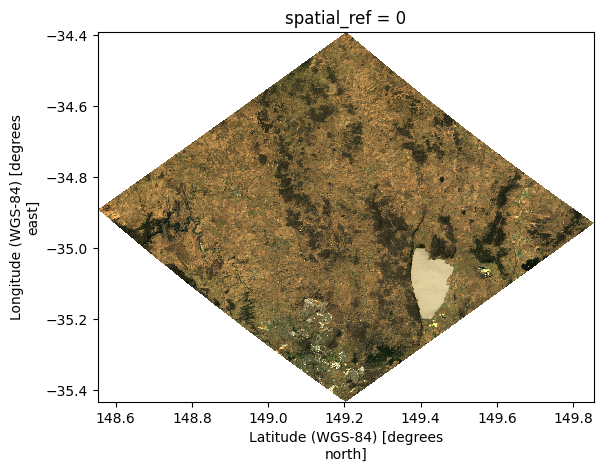

In [6]:
ds.drop_dims("bands").to_array().plot.imshow(x="longitude", y="latitude", robust=True, vmin=0, vmax=0.2)

## Plot the spectra at a point

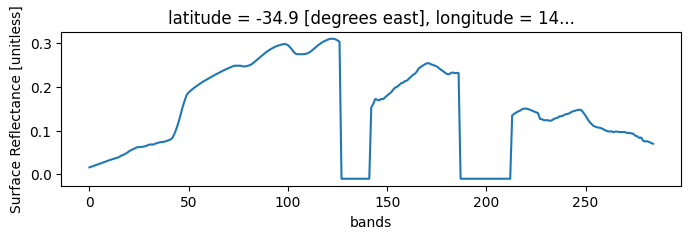

In [7]:
# Using matplotlib to plot the reflectance of a single location
example = ds['reflectance'].sel(longitude=149.2,latitude=-34.9, method='nearest')
example.plot(x='bands', size=2, aspect=4)

## Exporting data

In [ ]:
ds.red.rio.to_raster("red.tif")
ds.green.rio.to_raster("green.tif")
ds.blue.rio.to_raster("blue.tif")

In [ ]:
!gdal_merge.py -separate red.tif green.tif blue.tif -o rgb.tif 